<h1> PART 1 - CONVOLUTION </h1>

3. The time taken by the meanFilter() function increases as the kernel size 'k' increases because more pixels are considered by the kernel window which have to be summed up. Thus, as k increases, the time taken by the function also increases, implying that the time complexity is a function of kernel size.                                                 As the image dimensions (h and w) increases we have more pixels to move the convolution kernel over and hence, the function time also increases with increase in image dimensions.

4. The standard deviation of a guassian function measures how 'spread out' the function is. Thus, the function is wider as the standard deviation increases. In an image, this translates as an increase in blurring due to large standard deviation (>2). Thus, an increase in standard deviation causes more blurring.



In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

def conv2D(img,kernel):
    h,w = img.shape[0:2]
    k = kernel.shape[0]
    padding = int(k/2)
    
    # padded = np.zeros((h + padding*2, w + padding*2)) #extra zeroes so that kernel fits properly
    # padded[padding:h+padding,padding:w+padding] = img[:,:,0] #setting everything except the padding to be equal to image
    
    padded = np.pad(img,int(k/2), 'constant', constant_values=(0))
    output = np.zeros((h,w))
    for i in range(padding, h+padding):
        for j in range(padding, w+padding):
            # print(padded[j-padding: j+padding+1, i-padding: i+padding+1])
            output[i - padding,j-padding] = (kernel * padded[i-padding: i+padding+1, j-padding: j+padding+1]).sum()
    
    output = (np.stack((output,output,output),axis=2)).astype(np.uint8) #stacking the channels together
    return output

def meanFilter(img,size):
    kernel = np.zeros((size,size))
    # mean filter has value of 1/size*size
    den = size * size
    kernel[:,:] = 1/den
    output = conv2D(img,kernel)
    return output

Text(0.5, 1.0, 'Mean Filter Output (k=5)')

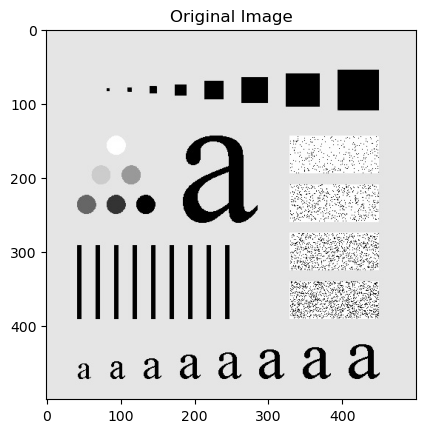

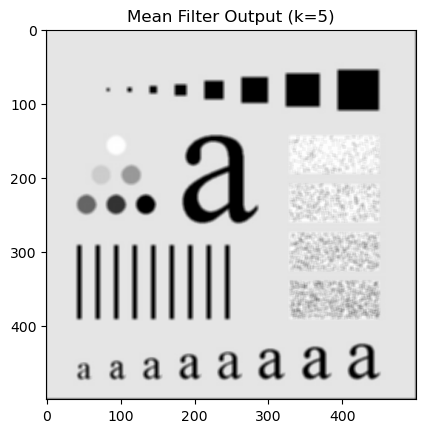

In [2]:
img = cv.imread("Images/testPattern.jpg")
plt.figure()
plt.imshow(img)
plt.title("Original Image")

result = meanFilter(img[:,:,0], 5)
plt.figure()
plt.imshow(result)
plt.title("Mean Filter Output (k=5)")

Text(0.5, 1.0, 'Mean Filter Output (k=101)')

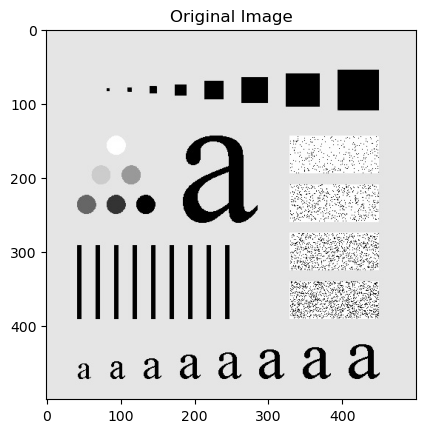

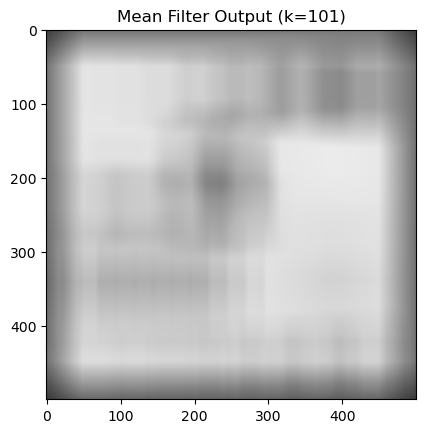

In [3]:
#changing kernel size
img = cv.imread("Images/testPattern.jpg")
plt.figure()
plt.imshow(img)
plt.title("Original Image")

result = meanFilter(img[:,:,0], 101)
plt.figure()
plt.imshow(result)
plt.title("Mean Filter Output (k=101)")

In [4]:
def guassianFilter(img,size,sd):
    kernel = np.zeros((size,size))
    # gaussian filter has different values based on sd
    norm = 0
    den1 = 2*sd*sd
    ranges = int(size/2)
    
    for i in range(-ranges,ranges+1):
        for j in range(-ranges,ranges+1):
            exp = np.exp(-((i*i + j*j)/den1))
            exp/=den1*np.pi
            kernel[i+ranges,j+ranges] = exp
            norm+=exp
            
    kernel = kernel/norm
    return conv2D(img,kernel)

Text(0.5, 1.0, 'Guassian Filter Output (size=51, sd=10)')

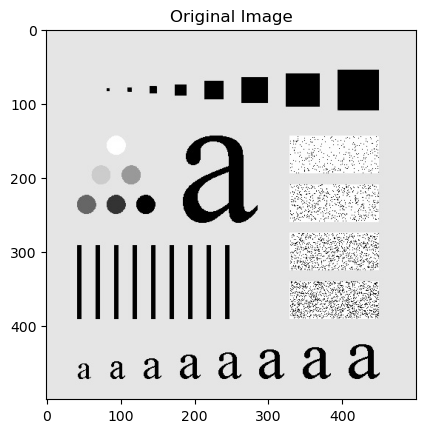

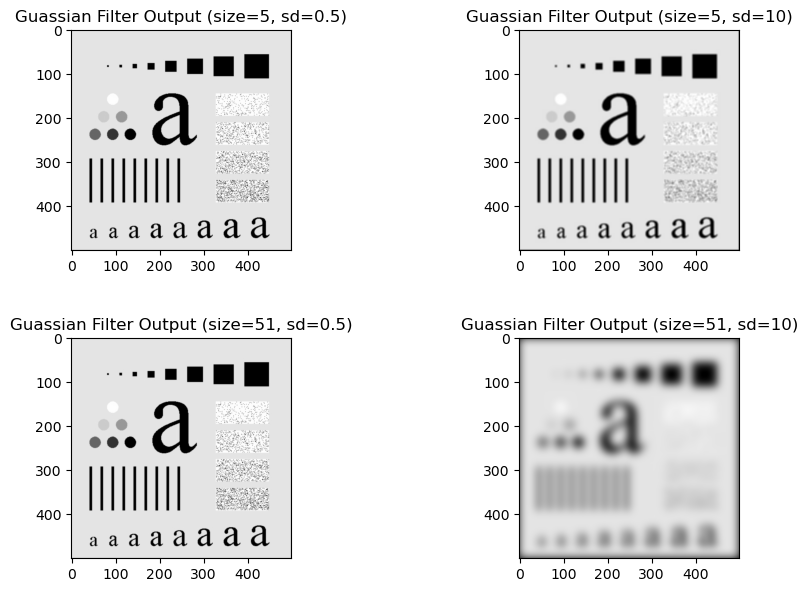

In [5]:
#gaussian kernel
img = cv.imread("Images/testPattern.jpg")
plt.figure()
plt.imshow(img)
plt.title("Original Image")

result = guassianFilter(img[:,:,0], 5, 0.5)
plt.figure()
plt.subplot(2,2,1)
# adjust spacing between plots
plt.subplots_adjust(left=0.3,
                    bottom=0.1,
                    right=1.5,
                    top=1.2,
                    wspace=0.4,
                    hspace=0.4)

plt.imshow(result)
plt.title("Guassian Filter Output (size=5, sd=0.5)")

result = guassianFilter(img[:,:,0], 5, 10)
plt.subplot(2,2,2)
plt.imshow(result)
plt.title("Guassian Filter Output (size=5, sd=10)")

result = guassianFilter(img[:,:,0], 51, 0.5)
plt.subplot(2,2,3)
plt.imshow(result)
plt.title("Guassian Filter Output (size=51, sd=0.5)")

result = guassianFilter(img[:,:,0], 51, 10)
plt.subplot(2,2,4)
plt.imshow(result)
plt.title("Guassian Filter Output (size=51, sd=10)")


<h1> PART 2 - NEED FOR SPEED </h1>

The main idea of the speed mean filtering algortihm is to use the already computed sums again instead of having to recompute them. We notice that the runtime of this algorithm is independent of the kernel size 'k'.

In [6]:
def speedyMeanFilter(img,k):
    h = img.shape[0]
    w = img.shape[1]
    img = np.pad(img,int(k/2), 'edge')
    
    output = np.zeros((h,w,3))
    s = np.zeros(k)
    
    for i in range(h):
        j = 0
        
        for p in range(k):
            s[p] = np.sum(img[i:i+k, p]) 
             
        summed = np.sum(s)
        output[i][j] = summed/(k*k)
        
        index = 0
        for j in range(1,w):
            summed -= s[index]
            s[index] = np.sum(img[i:i+k, j + (k // 2)])
            summed += s[index]
            output[i][j] = summed/(k*k)
            index+=1
            if index>=k:
                index = 0
    
    return output
        

Text(0.5, 1.0, 'Mean Filter Output (k=5)')

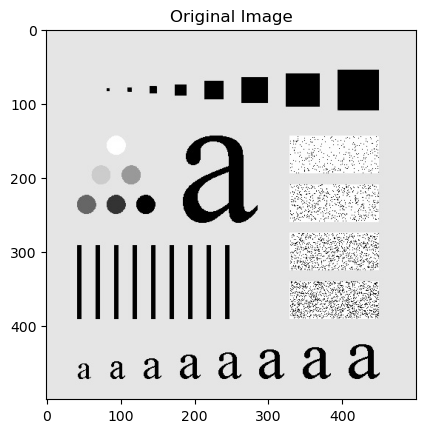

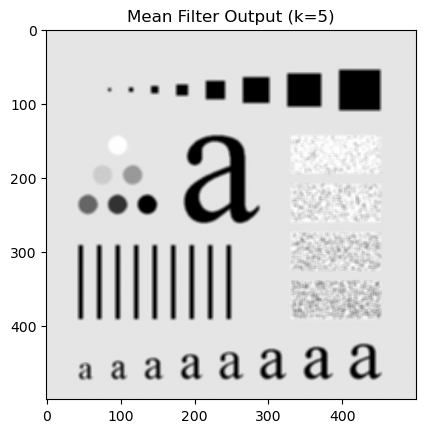

In [7]:
img = cv.imread("Images/testPattern.jpg")
plt.figure()
plt.imshow(img)
plt.title("Original Image")

output = speedyMeanFilter(img, 5)
output = (output - np.min(output)) / (np.max(output) - np.min(output)) #normalizing output
plt.figure()
plt.imshow(output)
plt.title("Mean Filter Output (k=5)")

[0.6871302127838135, 0.7310531139373779, 0.8056728839874268, 1.5201337337493896]
[0.9547703266143799, 0.957521915435791, 0.9621028900146484, 1.0503268241882324]


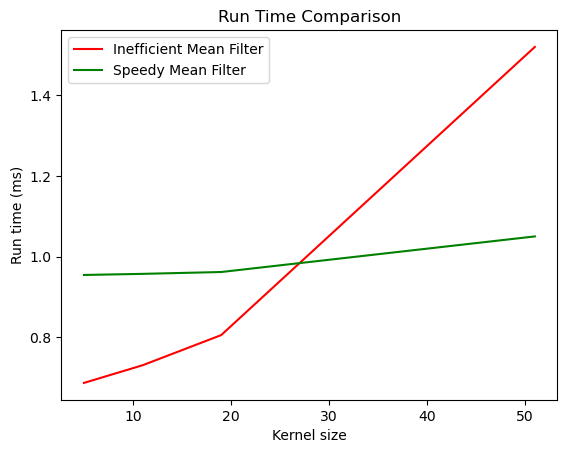

In [8]:
#comparing time for both algorithms
import time 

# for mean filter
k = [5, 11, 19, 51]
times = []
for i in range(4):
    start = time.time()
    output = meanFilter(img[:,:,0],k[i])
    end = time.time()
    times.append(end - start)

print(times)
plt.figure()
plt.plot(k,times, color='r', label = 'Inefficient Mean Filter')

times = []
for i in range(4):
    start = time.time()
    output = speedyMeanFilter(img[:,:,0],k[i])
    end = time.time()
    times.append(end - start)
    
print(times)
plt.plot(k,times, color='g', label = 'Speedy Mean Filter')
plt.title("Run Time Comparison")
plt.xlabel("Kernel size")
plt.ylabel("Run time (ms)")
plt.legend()
plt.show()

<h1> PART 3 - SALT AND PEPPER </h1>

1. 'pepper_noise.png' has salt noise and a minFilter is used to remove the noise.   
2. 'salt_noise.png' has pepper noise and a maxFilter is used to remove the nosie
3. 'salt_and_pepper_noise.png' has both salt and pepper noise and thus a median filter is used to remove the noise

In [9]:
#salt_noise.png -> the noise is pepper noise
# so to fix it we implement a maxFilter
def maxFilter(img,k):
    h,w = img.shape[0:2]
    padding = int(k/2)
    
    # padded = np.zeros((h + padding*2, w + padding*2)) #extra zeroes so that kernel fits properly
    # padded[padding:-padding,padding:-padding] = img[:,:,0] #setting everything except the padding to be equal to image
    
    padded = np.pad(img,int(k/2), 'edge')
    output = np.zeros((h,w))
    for i in range(padding, h+padding):
        for j in range(padding, w+padding):
            # print(padded[j-padding: j+padding+1, i-padding: i+padding+1])
            output[i - padding,j-padding] = np.max(padded[i-padding: i+padding+1, j-padding: j+padding+1])
            
    output = (np.stack((output,output,output),axis=2)).astype(np.uint8) #stacking the channels together
    return output


Text(0.5, 1.0, 'Max Fileting Output')

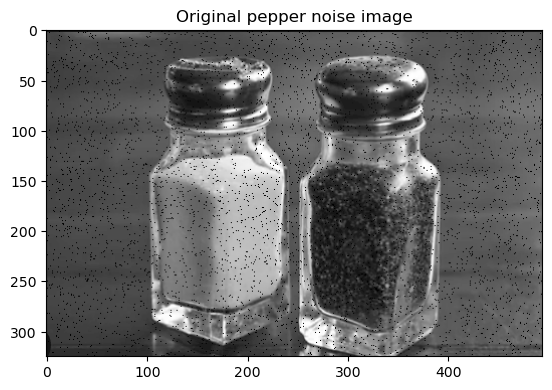

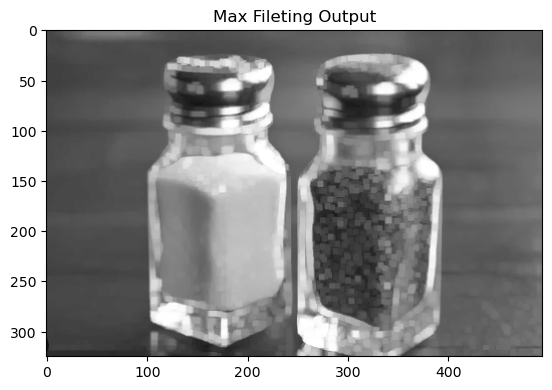

In [10]:
img = cv.imread("Images/salt_noise.png")
plt.figure()
plt.imshow(img)
plt.title("Original pepper noise image")

result = maxFilter(img[:,:,0], 5)
plt.figure()
plt.imshow(result)
plt.title("Max Fileting Output")

In [11]:
#pepper_noise.png -> the noise is salt noise
# so to fix it we implement a minFilter
def minFilter(img,k):
    h,w = img.shape[0:2]
    padding = int(k/2)
    
    # padded = np.ones((h + padding*2, w + padding*2)) #extra zeroes so that kernel fits properly
    # padded[padding:-padding,padding:-padding] = img[:,:,0] #setting everything except the padding to be equal to image
    
    padded = np.pad(img,int(k/2), 'edge')
    output = np.zeros((h,w))
    for i in range(padding, h+padding):
        for j in range(padding, w+padding):
            # print(padded[j-padding: j+padding+1, i-padding: i+padding+1])
            output[i - padding,j-padding] = np.min(padded[i-padding: i+padding+1, j-padding: j+padding+1])
            
    output = (np.stack((output,output,output),axis=2)).astype(np.uint8) #stacking the channels together
    return output

Text(0.5, 1.0, 'Min Fileting Output')

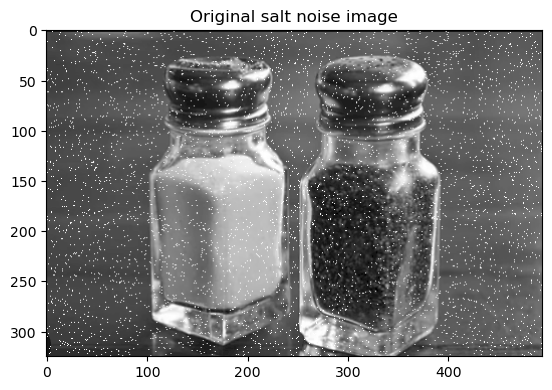

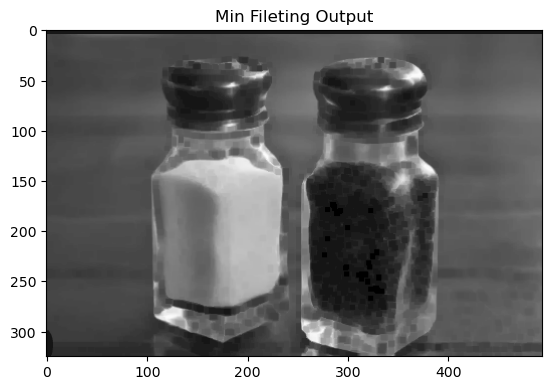

In [12]:
img = cv.imread("Images/pepper_noise.png")
plt.figure()
plt.imshow(img)
plt.title("Original salt noise image")

result = minFilter(img[:,:,0], 5)
plt.figure()
plt.imshow(result)
plt.title("Min Fileting Output")

In [13]:
#salt_and_pepper_noise.png -> the noise is salt and pepper noise
# so to fix it we implement a medianFilter
def medianFilter(img,k):
    h,w = img.shape[0:2]
    padding = int(k/2)
    
    # padded = np.ones((h + padding*2, w + padding*2)) #extra zeroes so that kernel fits properly
    # padded[padding:-padding,padding:-padding] = img[:,:,0] #setting everything except the padding to be equal to image
    
    padded = np.pad(img,int(k/2), 'edge')
    output = np.zeros((h,w))
    for i in range(padding, h+padding):
        for j in range(padding, w+padding):
            # print(padded[j-padding: j+padding+1, i-padding: i+padding+1])
            output[i - padding,j-padding] = np.median(padded[i-padding: i+padding+1, j-padding: j+padding+1])
            
    output = (np.stack((output,output,output),axis=2)).astype(np.uint8) #stacking the channels together
    return output

Text(0.5, 1.0, 'Median Fileting Output')

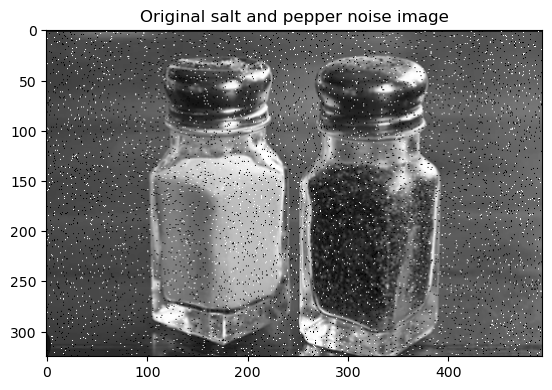

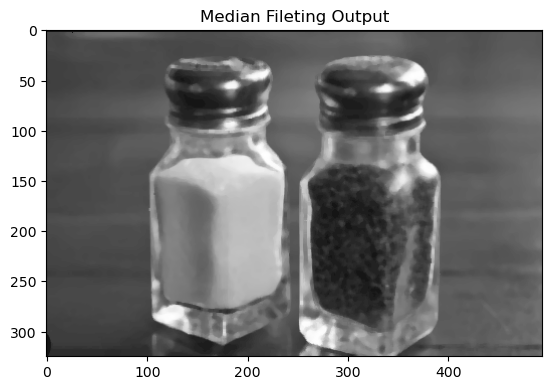

In [14]:
img = cv.imread("Images/salt_and_pepper_noise.png")
plt.figure()
plt.imshow(img)
plt.title("Original salt and pepper noise image")

result = medianFilter(img[:,:,0], 5)
plt.figure()
plt.imshow(result)
plt.title("Median Fileting Output")

<h1> PART 4 - BLURRY? DON'T WORRY </h1>
3. While both the mean and guassian filters cause the resulting images to become blurry, the main difference between the two is that the transition between edges is smoother in guassian when comapred to the mean filter. Due to the curve nature of the guassian filter, all pixels don't have the same weight (unlike the mean filter) and thus, the gradient is smoother. Hence, the final high boost guassian filtering image is also sharper than the mean filter image.

In [15]:
def sharpen(img,A,k):
    blur = meanFilter(img,k)
    
    detail = img - blur[:,:,0]
    detail = np.clip(detail, 0, 255).astype(np.uint8)
    
    output = img + np.clip(A*detail,0,255).astype(np.uint8)
    output = np.clip(output, 0, 255).astype(np.uint8)
    output = (np.stack((output,output,output),axis=2)).astype(np.uint8) #stacking the channels together
    return output

Text(0.5, 1.0, 'High Boost Filtering Output (A=9)')

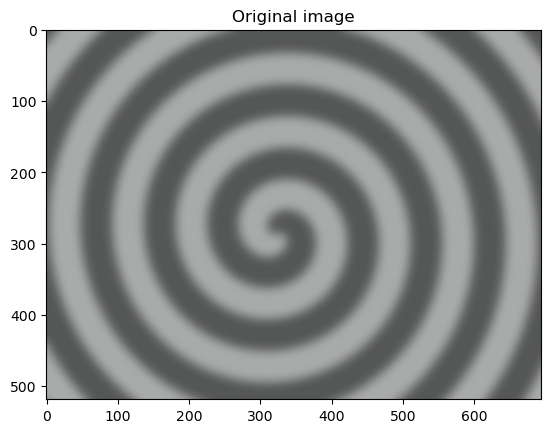

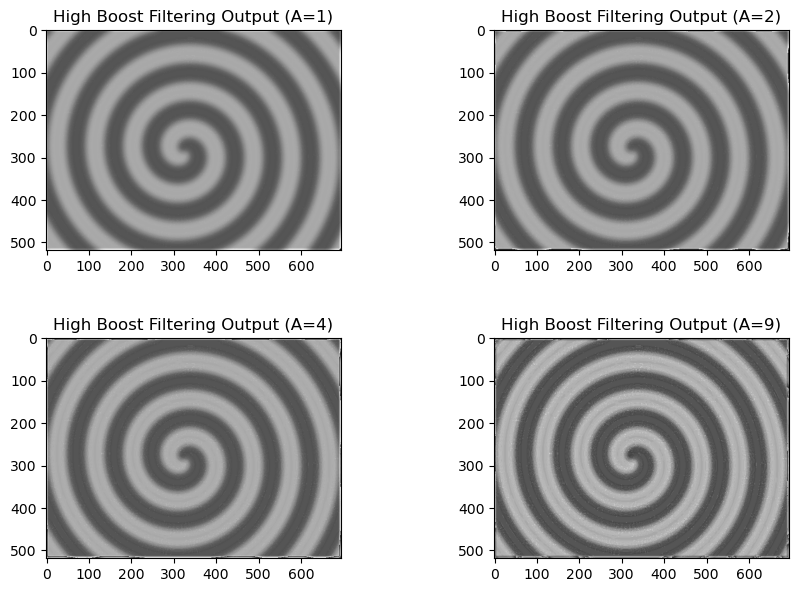

In [16]:
img = cv.imread("Images/blurry_spiral.png")
plt.figure()
plt.imshow(img)
plt.title("Original image")

result = sharpen(img[:,:,0], 1,11)
plt.figure()
plt.subplot(2,2,1)
# adjust spacing between plots
plt.subplots_adjust(left=0.3,
                    bottom=0.1,
                    right=1.5,
                    top=1.2,
                    wspace=0.4,
                    hspace=0.4)

plt.imshow(result)
plt.title("High Boost Filtering Output (A=1)")

result = sharpen(img[:,:,0], 2,11)
plt.subplot(2,2,2)
plt.imshow(result)
plt.title("High Boost Filtering Output (A=2)")

result = sharpen(img[:,:,0], 4,11)
plt.subplot(2,2,3)
plt.imshow(result)
plt.title("High Boost Filtering Output (A=4)")

result = sharpen(img[:,:,0], 9,11)
plt.subplot(2,2,4)
plt.imshow(result)
plt.title("High Boost Filtering Output (A=9)")

In [17]:
def sharpenGuass(img,A,k):
    blur = guassianFilter(img[:,:,0],k,100)
    
    detail = img[:,:,0] - blur[:,:,0]
    detail = np.clip(detail, 0, 255).astype(np.uint8)
    detail = (np.stack((detail,detail,detail),axis=2)).astype(np.uint8) #stacking the channels together
    output = img[:,:,0] + np.clip(A*detail[:,:,0],0,255).astype(np.uint8)
    output = np.clip(output, 0, 255).astype(np.uint8)
    output = (np.stack((output,output,output),axis=2)).astype(np.uint8) #stacking the channels together
    return output

Text(0.5, 1.0, 'High Boost Guassian Filtering Output (A=9)')

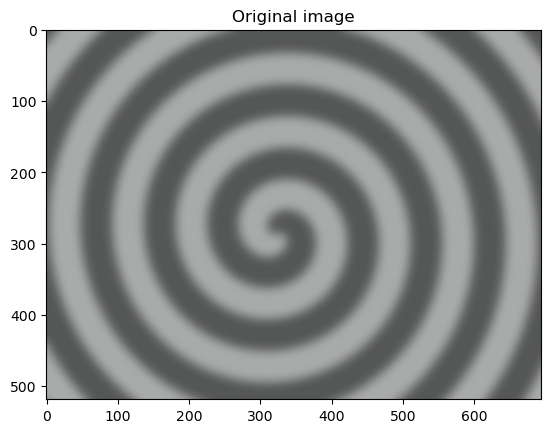

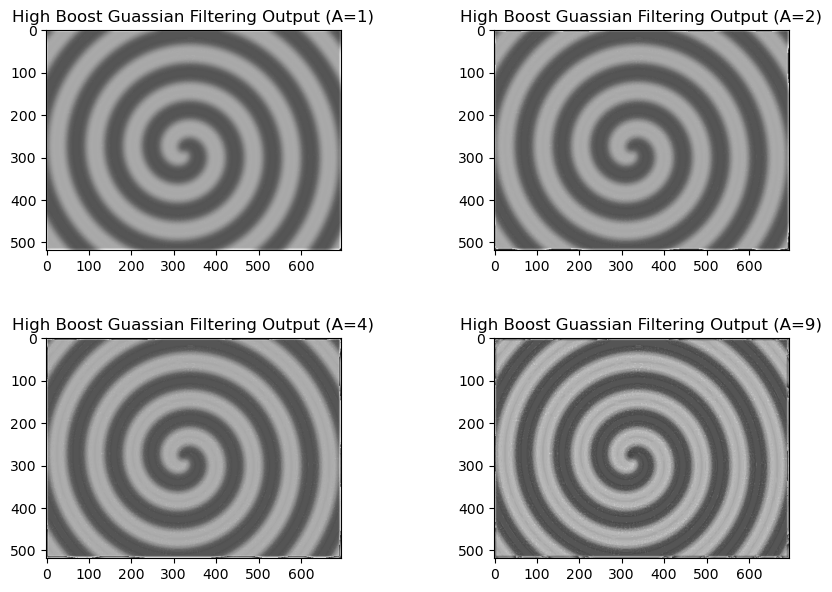

In [18]:
img = cv.imread("Images/blurry_spiral.png")
plt.figure()
plt.imshow(img)
plt.title("Original image")

result = sharpenGuass(img, 1,11)
plt.figure()
plt.subplot(2,2,1)
# adjust spacing between plots
plt.subplots_adjust(left=0.3,
                    bottom=0.1,
                    right=1.5,
                    top=1.2,
                    wspace=0.4,
                    hspace=0.4)

plt.imshow(result)
plt.title("High Boost Guassian Filtering Output (A=1)")

result = sharpenGuass(img, 2,11)
plt.subplot(2,2,2)
plt.imshow(result)
plt.title("High Boost Guassian Filtering Output (A=2)")

result = sharpenGuass(img, 4,11)
plt.subplot(2,2,3)
plt.imshow(result)
plt.title("High Boost Guassian Filtering Output (A=4)")

result = sharpenGuass(img, 9,11)
plt.subplot(2,2,4)
plt.imshow(result)
plt.title("High Boost Guassian Filtering Output (A=9)")

<h1> PART 5 - COUNTING COINS </h1>

3. Both Sobel and Prewitt filters are first order filters because they compute X-direction and Y-direction gradient separately and then the they are added to get the final edge image. The Laplacian filter is a second order filter that computes both X and Y gradients using one kernel. We notice that the Laplacian filter edge detection is better than the other two.

In [19]:
# Prewitt filter

def prewittFilter(img):
    img = img[:,:,0]
    gx = np.ones((3,3)) #[[-1,0,1],[-1,0,1],[-1,0,1]]
    gx[:,0] = -1
    gx[:,1] = 0
    
    gy = np.ones((3,3)) #[[1,1,1],[0,0,0],[-1,-1,-1]]
    gy[1,:] = 0
    gy[2,:] = -1
    
    ex = conv2D(img,gx)
    ey = conv2D(img,gy)
    output = ex + ey
    return [ex,ey,output]

Text(0.5, 1.0, 'Y direction gradient (Prewitt)')

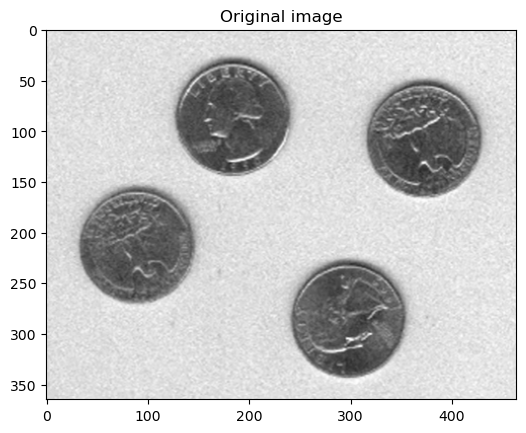

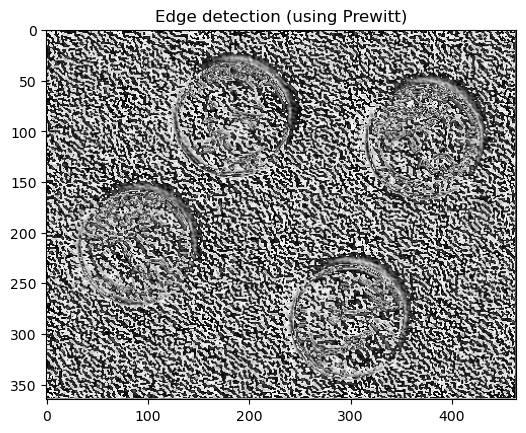

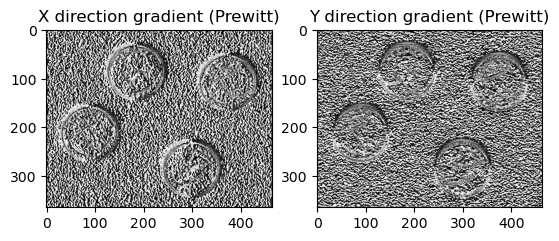

In [20]:
img = cv.imread("Images/coins.png")
plt.figure()
plt.imshow(img)
plt.title("Original image")

plt.figure()
[gx,gy,result] = prewittFilter(img)
plt.imshow(result)
plt.title("Edge detection (using Prewitt)")

plt.figure()
plt.subplot(1,2,1)
plt.imshow(gx)
plt.title("X direction gradient (Prewitt)")

plt.subplot(1,2,2)
plt.imshow(gy)
plt.title("Y direction gradient (Prewitt)")

In [21]:
# Sobel filter

def sobelFilter(img):
    img = img[:,:,0]
    gx = np.array([[-1,0,1],[-2,0,2],[-1,0,1]]) 
    gy = np.array([[1,2,1],[0,0,0],[-1,-2,-1]]) 
    
    ex = conv2D(img,gx)
    ey = conv2D(img,gy)
    output = ex + ey
    return [ex,ey,output]

Text(0.5, 1.0, 'Y direction gradient (Sobel)')

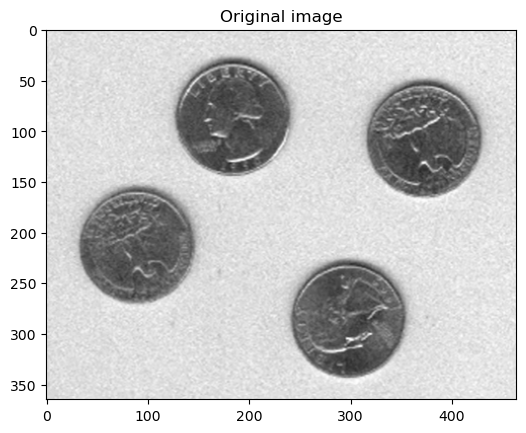

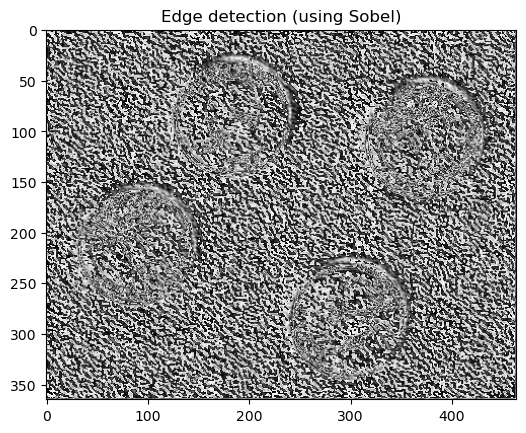

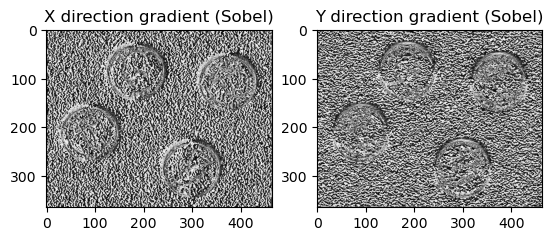

In [22]:
img = cv.imread("Images/coins.png")
plt.figure()
plt.imshow(img)
plt.title("Original image")

plt.figure()
[gx,gy,result] = sobelFilter(img)
plt.imshow(result)
plt.title("Edge detection (using Sobel)")

plt.figure()
plt.subplot(1,2,1)
plt.imshow(gx)
plt.title("X direction gradient (Sobel)")

plt.subplot(1,2,2)
plt.imshow(gy)
plt.title("Y direction gradient (Sobel)")

In [23]:
def LaplacianFilter(img):
    img = img[:,:,0]
    l = np.array([[0,-1,0],[-1,4,-1],[0,-1,0]]) 
    
    output = conv2D(img,l)
    return output

Text(0.5, 1.0, 'Edge detection (using Laplacian)')

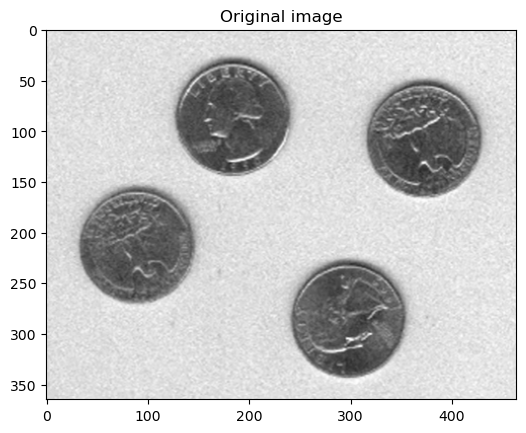

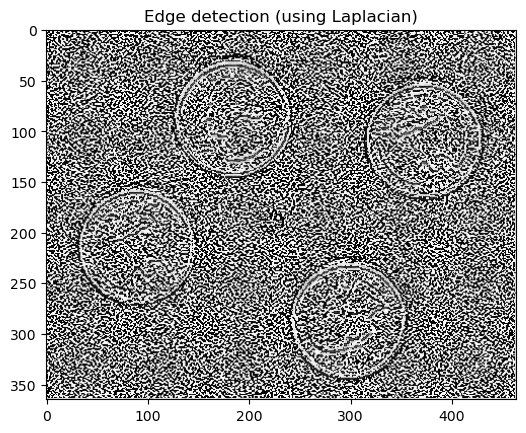

In [24]:
img = cv.imread("Images/coins.png")
plt.figure()
plt.imshow(img)
plt.title("Original image")

plt.figure()
result = LaplacianFilter(img)
plt.imshow(result)
plt.title("Edge detection (using Laplacian)")

<h1> PART 6 - HURRY! MAKT IT BLURRY </h1>

2. The two main parameters of the bilateral filter are the spatial standard deviation (sds) and the intensity range standard deviation (sdr). As the sdr increases, the bilateral filteral approaches the Guassian function. Since guassian function widens and flattens as sd increases, the output image becomes nearly constant over the intensity changes of the image. <br>
As the spatial sd increases, the larger features get smoothened.

3. Bilateral filtering is an extension of guassian filtering. While both guassian and bilateral filtering removes noise, guassian blurring also causes the edges to become smoother. Bilateral filtering takes into account the distance and the intensity value difference between pixels and thus, keeps the edges sharper while also blurring the noise.

In [25]:
def distance(x1,y1,x2,y2):
    return np.sqrt(np.abs((x2-x1)**2-(y2-y1)**2))

def gaussian(x,sd):
    den1 = 2*sd*sd
    exp = np.exp(-((x*x)/den1))
    exp *= (1/(np.pi*den1))
    return exp

def bilateralFilter(img,size,sds,sdr):
    h = img.shape[0]
    w = img.shape[1]
    img = img.astype(np.float64)

    output = np.zeros((h,w,3),dtype = np.uint8)

    for i in range(h):
        for j in range(w):
            den = 0
            pixel = np.zeros(3)
            for k in range(size):
                for l in range(size):
                    x = int(i - (size/2 - k))
                    y = int(j - (size/2 - l))
                    
                    if x>=h:
                        x-=h
                    if y>=w:
                        y-=w
                    
                    #spatial kernel gaussian 
                    gs = gaussian(distance(i,j,x,y),sds)
                    #intensity range kernel gaussian 
                    gr = gaussian(img[x][y]  - img[i][j],sdr)
                    
                    wp = gr*gs
                    den += wp
                    pixel = pixel + (img[x][y] * wp)
                    
            pixel = pixel/den
            output[i][j] = np.round(pixel).astype(np.uint8)
        
    return output 

Text(0.5, 1.0, 'Bilateral Filtering(k=5,sds=10,sdr=50)')

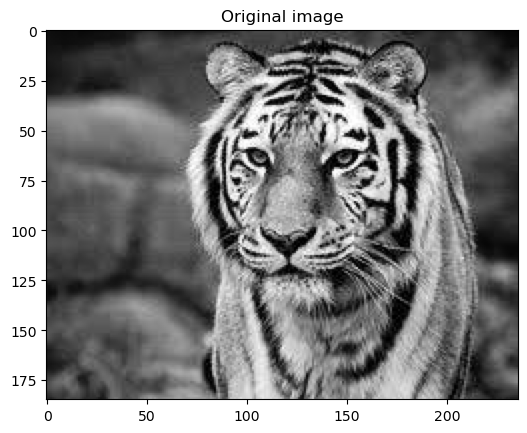

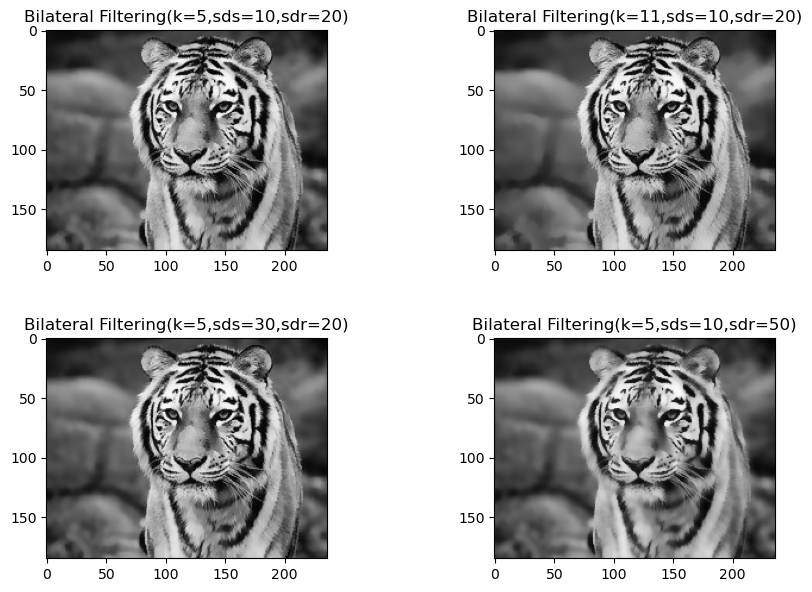

In [26]:
img = cv.imread("Images/tiger.jfif")
plt.figure()
plt.imshow(img)
plt.title("Original image")

plt.figure()
plt.subplot(2,2,1)
# adjust spacing between plots
plt.subplots_adjust(left=0.3,
                    bottom=0.1,
                    right=1.5,
                    top=1.2,
                    wspace=0.4,
                    hspace=0.4)

result = bilateralFilter(img,5,10,20)
plt.imshow(result)
plt.title("Bilateral Filtering(k=5,sds=10,sdr=20)")

plt.subplot(2,2,2)
result = bilateralFilter(img,11,10,20)
plt.imshow(result)
plt.title("Bilateral Filtering(k=11,sds=10,sdr=20)")

plt.subplot(2,2,3)
result = bilateralFilter(img,5,30,20)
plt.imshow(result)
plt.title("Bilateral Filtering(k=5,sds=30,sdr=20)")

plt.subplot(2,2,4)
result = bilateralFilter(img,5,10,50)
plt.imshow(result)
plt.title("Bilateral Filtering(k=5,sds=10,sdr=50)")